# Optimising site polygons
* Simply defining polygons and rotating to fit will not work in all cases - e.g.: Hornsea 2
* Instead, we can deform an initial shape to fit the boundary.

Imports

In [33]:
import os
from platypus import NSGAII, Problem, Real, Integer, nondominated_sort, SBX, PM, GAOperator, Evaluator, run_job, Archive, Solution, nondominated, InjectedPopulation, Mutation, NSGAIII, Variator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
from shapely.geometry import Polygon, shape, Point
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity
import random
import copy
from joblib import Parallel, delayed
import multiprocessing
from OSGridConverter import latlong2grid, grid2latlong
import matplotlib
import plotly.express as px
import seaborn
from shapely.ops import nearest_points
from functools import partial
from shapely.ops import transform
import pyproj
import math

Helpers

In [34]:
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518


In [35]:
def getCorners(lon, lat, turbnum):

    lonRads = np.radians(lon)
    latRads = np.radians(lat)

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # N turbines * 500m radius, into km 
    distance = int(length_turbnum * 0.5)

    corners = []

    for bearing in [45, 135, 225, 315]:
        bearingRads = np.radians(bearing)

        maxLatRads = np.arcsin(np.sin(latRads) * np.cos(distance / 6371) + np.cos(latRads) * np.sin(distance / 6371) * np.cos(bearingRads))
        maxLonRads = lonRads + np.arctan2(np.sin(bearingRads) * np.sin(distance / 6371) * np.cos(latRads), np.cos(distance / 6371) - np.sin(latRads) * np.sin(maxLatRads))

        maxLat = np.degrees(maxLatRads)
        maxLon = np.degrees(maxLonRads)

        corners.append([maxLon, maxLat])

    """
    grid = latlong2grid(lat, lon)
    easting, northing = grid.eastNorth()

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # length of lon / lat dimensions from 500m radius / turbine in metres
    # divide by 10.0 to get northing/easting conversion to 10x10m national grid = 50.0
    eastNorth_offset = int(length_turbnum * 50.0)

    # calculate easting northings of corners
    q1_easting, q1_northing = easting - eastNorth_offset, northing + eastNorth_offset
    q2_easting, q2_northing = easting + eastNorth_offset, northing + eastNorth_offset
    q3_easting, q3_northing = easting + eastNorth_offset, northing - eastNorth_offset
    q4_easting, q4_northing = easting - eastNorth_offset, northing - eastNorth_offset

    # calculate lons and lats of corners
    q1 = grid2latlong(f'TB {str(q1_easting)[1:]} {str(q1_northing)[1:]}', tag='WGS84')
    q2 = grid2latlong(f'TB {str(q2_easting)[1:]} {str(q2_northing)[1:]}', tag='WGS84')
    q3 = grid2latlong(f'TB {str(q3_easting)[1:]} {str(q3_northing)[1:]}', tag='WGS84')
    q4 = grid2latlong(f'TB {str(q4_easting)[1:]} {str(q4_northing)[1:]}', tag='WGS84')

    q1_lon, q1_lat = q1.longitude, q1.latitude
    q2_lon, q2_lat = q2.longitude, q2.latitude
    q3_lon, q3_lat = q3.longitude, q3.latitude
    q4_lon, q4_lat = q4.longitude, q4.latitude

    # calculate offsets from centre
    q1_lon_offset = q1_lon - lon
    q1_lat_offset = q1_lat - lat
    q2_lon_offset = q2_lon - lon
    q2_lat_offset = q2_lat - lat
    q3_lon_offset = q3_lon - lon
    q3_lat_offset = q3_lat - lat
    q4_lon_offset = q4_lon - lon
    q4_lat_offset = q4_lat - lat

    return q1_lon_offset, q1_lat_offset, q2_lon_offset, q2_lat_offset, q3_lon_offset, q3_lat_offset, q4_lon_offset, q4_lat_offset
    """

    return corners

Load data

In [36]:
lat_range = (53.486257927, 54.1)
lon_range = (0.5, 2.5571098)

In [37]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("data/UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

map_polygon = Polygon(polygon_np)


In [38]:
file = 'data/UKHO ADMIRALTY bathymetry UK east coast.csv'
admiralty_df = pd.read_csv(file, sep=',')
admiralty_df = admiralty_df[admiralty_df['Depth'] > -40]

In [39]:
known_owf_locations = pd.read_csv("data/UK east coast wind energy locations.csv")

turbnum_range = (165, 174)  # min max turbnums in known truthes

# filter out Hornsea 3 and 4, as still under construction
known_owf_locations = known_owf_locations[known_owf_locations['TURBNUM'].isin([165, 174])]

# drop easting and northing columns
known_owf_locations = known_owf_locations.drop(columns=['EASTING', 'NORTHING'])

# rename lat lng to lat lon
known_owf_locations = known_owf_locations.rename(columns={'LAT': 'lat', 'LNG': 'lon', 'TURBNUM': 'turbnum'})

known_owf_locations

# drop hornsea 1 (turbnum 174.0)
known_owf_locations = known_owf_locations[known_owf_locations['turbnum'] != 174.0]

Visualise

0.00989747233353909
0.009897472335530054


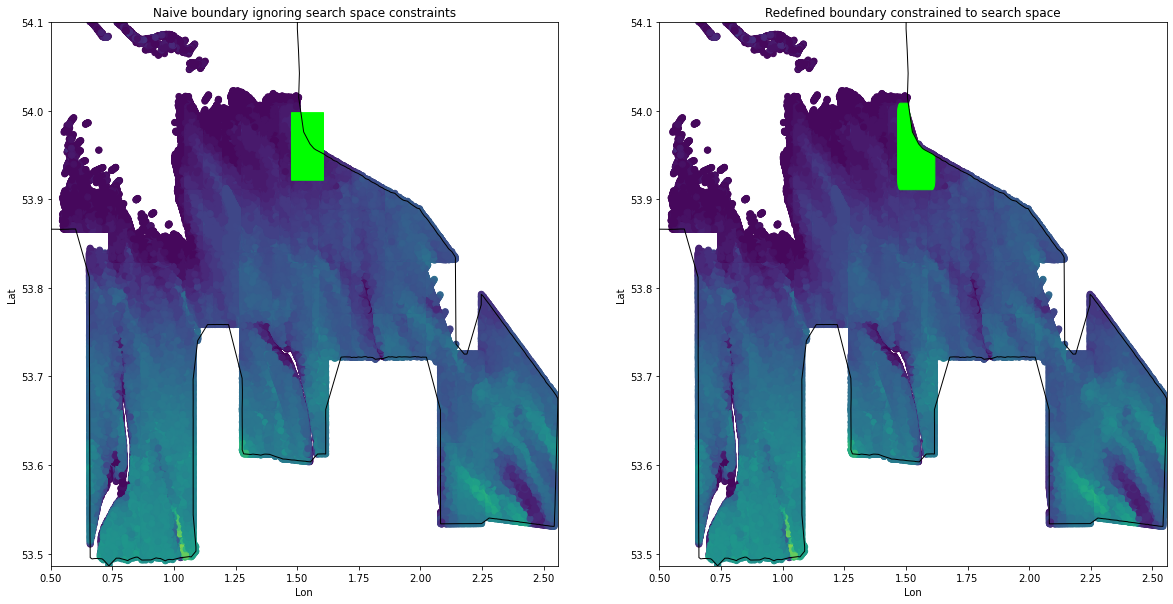

In [40]:
# plot contrained to search space
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# naive polygons
ax = axes[0]

ax.set_title("Naive boundary ignoring search space constraints")

map = ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")

for idx, row in known_owf_locations.iterrows():
    lon, lat = row['lon'], row['lat']
    turbnum = row['turbnum']

    q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)

    def rotate(points, origin, angle):
        xy = (points - origin) * np.exp(complex(0, angle)) + origin
        return xy.real, xy.imag
    
    rotation = 0

    q1_coord = rotate(complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q2_coord = rotate(complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q3_coord = rotate(complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q4_coord = rotate(complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation))

    p = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
    polygon = Polygon(p)

    patch = PolygonPatch(polygon, fc="#00ff00", ec="#00ff00", fill=True)
    ax.add_patch(patch)

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# buffer solutions into map polygon
ax = axes[1]

ax.set_title("Redefined boundary constrained to search space")

map = ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")

for idx, row in known_owf_locations.iterrows():
    lon, lat = row['lon'], row['lat']
    turbnum = row['turbnum']

    q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)

    def rotate(points, origin, angle):
        xy = (points - origin) * np.exp(complex(0, angle)) + origin
        return xy.real, xy.imag
    
    rotation = 0

    q1_coord = rotate(complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q2_coord = rotate(complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q3_coord = rotate(complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q4_coord = rotate(complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation))

    p = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
    polygon = Polygon(p)

    print(polygon.area)

    target = polygon.area
    maxR = pow(target/3.141593, 0.5)
    tolerance = 0.0000000001
    lower_bound = 0.0001

    # iterate till area outside of map polygon is less than lower bound (redistributed back inside polygon)
    while True:
        intersection = polygon.intersection(map_polygon)

        # catch case where polygon is entirely outside or >40% outside of map polygon
        # only repair solutions with >60% of area inside map polygon (bound decided by Hornsea 2 intersection at 0 degrees)
        if intersection.area == 0 or intersection.area > 0.4:
            break

        elif 1 - (intersection.area / polygon.area) > lower_bound:
            low, high = 0, maxR

            while True:
                middle=0.5*(low+high)
                
                newPolygon = intersection.buffer(middle)
                
                if (high-low) < tolerance:
                    break
                
                if newPolygon.area < target:
                    low = middle
                else:
                    high = middle
            
            polygon = newPolygon
        else:
            break   # exit once difference is empty or below lower bound

    print(polygon.area)
    patch = PolygonPatch(polygon, fc="#00ff00", ec="#00ff00", fill=True)
    ax.add_patch(patch)

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

pl.show()